## Population dynamics
This code examines how population of neurons change their firing patterns across time using dimensionality reduction and network dynamics analysis

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [5]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [6]:
# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-06-26'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-06-26'
f = h5py.File(data_path/'2023-06-26_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-06-26_multiple_regression_result.hdf5','r')

In [7]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [8]:
df = h5_to_df(f2)
df = df[(df['Region']=='PER')&(df['Response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['Preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = np.argmax(f[f'{key}/anova_eta'])*10
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['Selectivity index']
    
    if f[key].attrs['Preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        df.loc[df['key']==key,'coef_pref_int'] = f2[f'{key}/basic/beta_coef'][2]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][3]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][4]
        df.loc[df['key']==key,'coef_nonpref_int'] = f2[f'{key}/basic/beta_coef'][5]
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][3]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][4]
        df.loc[df['key']==key,'coef_pref_int'] = f2[f'{key}/basic/beta_coef'][5]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        df.loc[df['key']==key,'coef_nonpref_int'] = f2[f'{key}/basic/beta_coef'][2]
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

In [87]:
for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:
        df.loc[i,'peak_selectivity_time_range2'] = 0
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Classifying visual, auditory, and unbiased neurons

In [9]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,3],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,4])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'unbiased'

### Exploratory data analysis on the interaction term

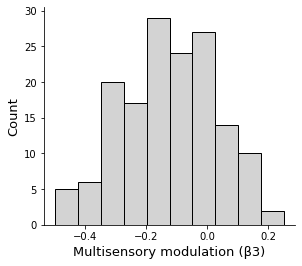

In [91]:
fig,ax = plt.subplots(figsize=(4.5,4))

ax.hist(df['coef_pref_int'], color = 'lightgray', ec='black')
ax.set_xlabel('Multisensory modulation (\u03B23)', fontsize=13);
ax.set_ylabel('Count', fontsize=13);
plt.savefig(fig_path / 'interaction_histogram.png', dpi=300,facecolor='white')

### Classifying neurons based on multisensory modulation
(not used)

Multisensory inhibition / enhancement

In [75]:
crit = np.zeros((len(df),2))
for i in range(len(df)):
    key = df.loc[i,'key']
    
    if df.loc[i,'pref_obj'] == 'Boy':
        shuffle_int = f2[f'{key}/basic_shuffle/beta_coef'][:,2]
    else:
        shuffle_int = f2[f'{key}/basic_shuffle/beta_coef'][:,5]
    
    crit[i,0] = np.percentile(shuffle_int,5)
    crit[i,1] = np.percentile(shuffle_int,95)
    
    if df.loc[i,'coef_pref_int'] < crit[i,0]:
        df.loc[i,'multi'] = 'inhibit'
    elif df.loc[i,'coef_pref_int'] > crit[i,1]:
        df.loc[i,'multi'] = 'enhance'
    else:
        df.loc[i,'multi'] = 'none'

### Comparing multisensory modulation between cell categories

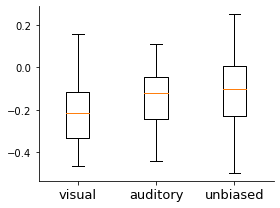

In [76]:
fig,ax = plt.subplots(figsize=(4,3))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'coef_pref_int'] for c in x]
ax.boxplot(y);
ax.set_xticklabels(x, fontsize=13);
#ax.set_xticks([0, 400, 900]);
#ax.set_xlabel('Peak selectivity time (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [77]:
pg.kruskal(data=df, dv='coef_pref_int', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,6.261452,0.043686


In [78]:
import scikit_posthocs as sp

data = [df.loc[df['Category']=='visual','coef_pref_int'],
        df.loc[df['Category']=='auditory','coef_pref_int'],
        df.loc[df['Category']=='unbiased', 'coef_pref_int']]
kruskal_posthoc = sp.posthoc_dunn(data, p_adjust = 'simes-hochberg')
kruskal_posthoc

,1,2,3
1,1.000000,0.324764,0.044465
2,0.324764,1.000000,0.324764
3,0.044465,0.324764,1.000000


### Relationship between multisensory modulation and modality bias

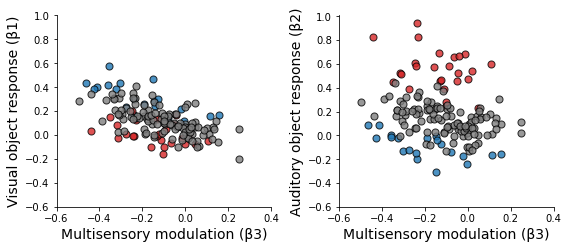

In [74]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'coef_pref_int']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)

ylabel = ['Visual object response (\u03B21)', 'Auditory object response (\u03B22)']
for i in range(2):
    ax[i].set_xticks(np.arange(-0.6,0.6,0.2));
    ax[i].set_xlabel('Multisensory modulation (\u03B23)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.6,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);

plt.tight_layout()
#plt.savefig(fig_path / 'coef_time_scatter.png', dpi=300,facecolor='white')

### Relationship between multisensory modulation and selectivity time

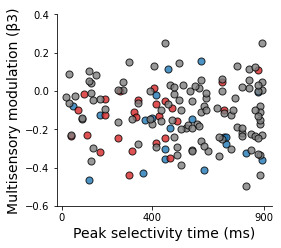

In [86]:
fig,ax = plt.subplots(figsize=(4,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'peak_selectivity_time']
    y = df.loc[df['Category']==cat[c],'coef_pref_int']
    ax.scatter(x, y, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)

ax.set_yticks(np.arange(-0.6,0.6,0.2));
ax.set_ylabel('Multisensory modulation (\u03B23)', fontsize=14);
ax.set_xticks([0, 400, 900]);
ax.set_xlabel('Peak selectivity time (ms)', fontsize=14);

plt.tight_layout()
#plt.savefig(fig_path / 'coef_time_scatter.png', dpi=300,facecolor='white')

                         Source        SS   DF        MS         F     p-unc  \
0  peak_selectivity_time_range2  0.015098    3  0.005033  0.209175  0.889925   
1                        Within  3.608901  150  0.024059       NaN       NaN   

        np2  
0  0.004166  
1       NaN  


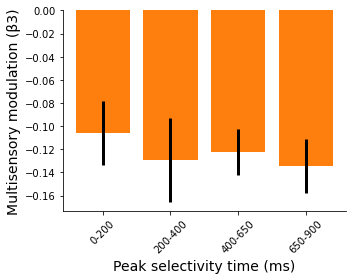

In [89]:
fig,ax = plt.subplots(figsize=(5,4))

x = range(4)
y = df.groupby('peak_selectivity_time_range2').mean()['coef_pref_int']
yerr = df.groupby('peak_selectivity_time_range2').sem()['coef_pref_int']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
#ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Multisensory modulation (\u03B23)',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(['0-200','200-400','400-650','650-900'])
ax.tick_params(axis='x',labelrotation=45);

plt.tight_layout()
#plt.show()
#plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')

anova_result = pg.anova(data=df, dv='coef_pref_int', between='peak_selectivity_time_range2', detailed=True)
print(anova_result)